# Exp 016: Report Results for Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

import sys
sys.path.append("../source")
from helpers import format_context, egp, get_prompt_task_2, get_prompt_task_3, get_preferred_nrs
from evaluation import calculate_distinct_n, gpt_metrics

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.22325737.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.22325737.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False, aggs = []):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_categories_neg': ['mean']} if 'num_categories_neg' in results.columns else {}
    neg_const = {agg: ['mean'] for agg in aggs} if aggs else {}
    agg_col = "num_categories" if 'num_categories_neg' in results.columns else "num_constraints"
    aggs = results.groupby(by).agg({f'{agg_col}_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in gpt_metrics.keys()}})
    return aggs

def plot_sat(res, col='num_constraints_sat', by='num_constraints', xlabel="Number of constraints", title="Relative amount of satisfied constraints", ylim=(0,1)):
    get_aggs(res, ["model", by], aggs=[col]).unstack(level=0)[col]['mean'].plot(kind='bar', rot=0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel("Success Rate")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        ax.annotate(txt, (x.iloc[i]+0.01, y.iloc[i]-0.02))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

def get_mean_distinct(model, single_constraints):
    return get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True)['responses0']['calculate_distinct_n'].mean()

def get_res(models, sources=['CMUDoG', 'ToC']):
    res = pd.DataFrame()
    
    for model in models:
        results = pd.read_json(f"../data/task1/{model}_eval.json")
        results = results[results['source'].isin(sources)]
        
        results['model']=model
        results = results[results['responses'].apply(len)>0]
        results['responses0'] = results['responses'].apply(lambda x: x[0])
        results['num_constraints'] = results['constraints'].apply(len)
        results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
        res = pd.concat([res, results])
    
    single_constraints = res[res['num_constraints']==1].copy()
    single_constraints = single_constraints[single_constraints['source'].isin(sources)]
    single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])
    return res, single_constraints

def plot_combined(res_melt, hue="Alpha", save=None, hue_order=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, y='Value', errorbar="ci", capsize=.1, hue_order = hue_order)

    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraint\nSatisfaction"
    
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

translation_dict = {
    'gpt35': 'GPT-3.5',
    'llama': 'Llama3',
    'llama-ft': 'Llama3 Fine-tune',
    'llama-FT-multi': 'Llama3 Fine-tune',
    'llama-decoding': 'Llama3 Decoding',
    'llama-decoding-2': 'Llama3 Decoding',
    'llama-ft-decoding': 'Llama3 Hybrid',
}
def translate_models(tab):
    tab.model = tab.model.map(translation_dict)

# Decoding Hyperparameter

In [97]:
models = ["decoding-0","decoding-09","decoding-095","decoding-099","decoding-0999","decoding-09999","decoding-1"]
res, _ = get_res(models)
get_aggs(res[res['num_constraints']>0], by=["model"])

num_constraints_sat       Appropriateness       Relevance  \
                              mean count            mean count      mean   
model                                                                      
decoding-0                0.357222   600        4.460000   100  4.450000   
decoding-09               0.503611   600        4.340000   100  4.300000   
decoding-095              0.551944   600        4.340000   100  4.410000   
decoding-099              0.633611   600        3.570000   100  3.710000   
decoding-0999             0.657500   600        2.390000   100  2.240000   
decoding-09999            0.651806   600        2.320000   100  2.170000   
decoding-1                0.654722   600        1.852941    34  1.764706   

                     Content Richness       Grammatical Correctness        
               count             mean count                    mean count  
model                                                                      
decoding-0       100         3.060000   100                4.900000   100  
decoding-09      100         3.070000   100                4.840000   100  
decoding-095     100         3.100000   100                4.760000   100  
decoding-099     100         2.660000   100                4.340000   100  
decoding-0999    100         1.900000   100                3.450000   100  
decoding-09999   100         1.820000   100                3.010000   100  
decoding-1        34         1.382353    34                2.676471    34

In [98]:
res_melt = res[['model','num_constraints_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_constraints_sat",'Value'] /= 5
res_melt['Alpha'] = res_melt['model'].map({"decoding-0": "0.0",
                                          "decoding-09": "0.9",
                                          "decoding-095": "0.95",
                                          "decoding-099": "0.99",
                                          "decoding-0999": "0.999",
                                          "decoding-09999": "0.9999",
                                          "decoding-1": "1.0"})

/tmp/ipykernel_3769160/2157838278.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_3769160/2157838278.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_3769160/2157838278.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


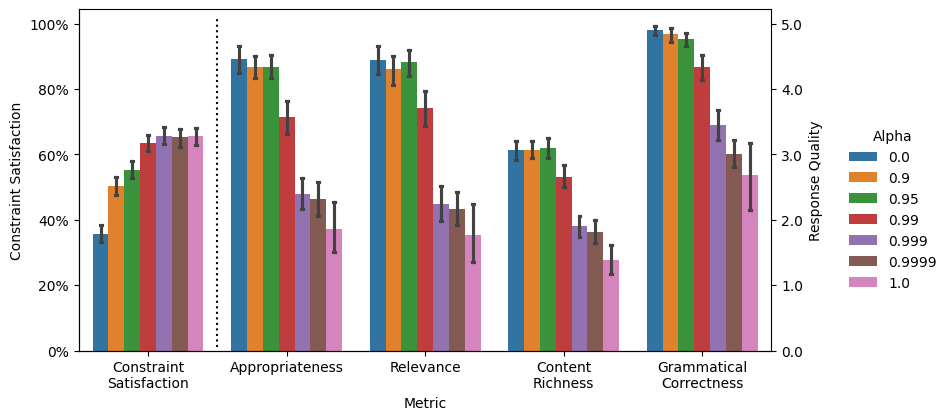

In [99]:
plot_combined(res_melt, save="../results/decoding_tuning.pdf")

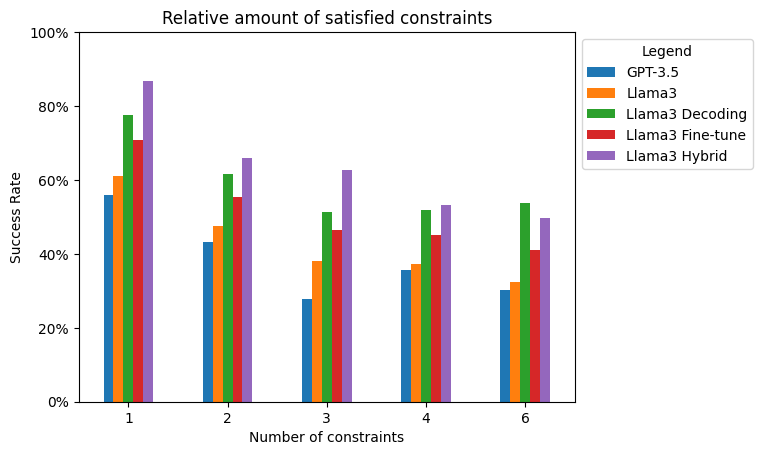

In [20]:
plot_sat(res)

In [13]:
models = ["gpt35", "llama", "llama-FT-multi", "llama-ft-decoding", "llama-decoding-2"]
res, single_constraints = get_res(models)

translate_models(res)
translate_models(single_constraints)

get_aggs(res, by=["model"])

num_constraints_sat       Appropriateness       Relevance  \
                                mean count            mean count      mean   
model                                                                        
GPT-3.5                     0.484178  1322        4.755747   348  4.790230   
Llama3                      0.531455  1322        4.452088   407  4.348894   
Llama3 Decoding             0.695852  1322        4.308824   408  4.274510   
Llama3 Fine-tune            0.615356  1322        4.086207   406  3.977833   
Llama3 Hybrid               0.764561  1322        3.448020   404  3.316832   

                       Content Richness       Grammatical Correctness        
                 count             mean count                    mean count  
model                                                                        
GPT-3.5            348         3.097701   348                4.965517   348  
Llama3             407         2.904177   407                4.916462   407  
Llama3 Decoding    408         2.803922   408                4.872549   408  
Llama3 Fine-tune   406         2.290640   406                4.701970   406  
Llama3 Hybrid      404         2.017327   404                4.131188   404

# Task 1

/tmp/ipykernel_109428/2157838278.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_109428/2157838278.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_109428/2157838278.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


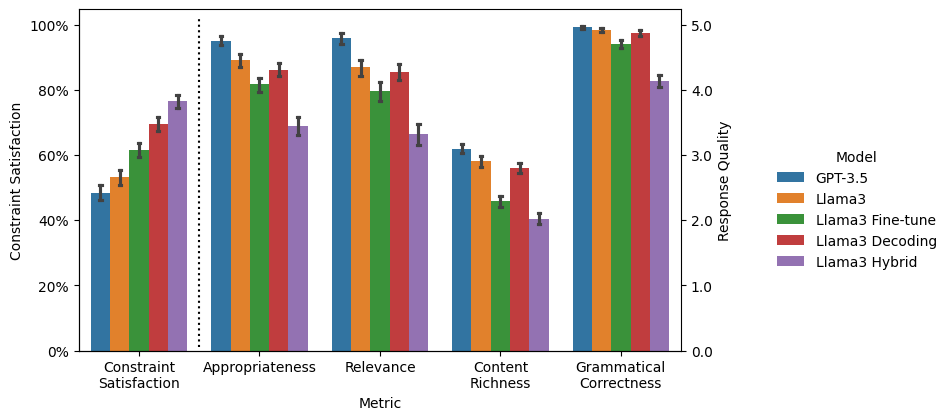

In [14]:
res_melt = res[['model','num_constraints_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_constraints_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task1.pdf", hue_order=['GPT-3.5', 'Llama3', 'Llama3 Fine-tune', 'Llama3 Decoding', 'Llama3 Hybrid'])

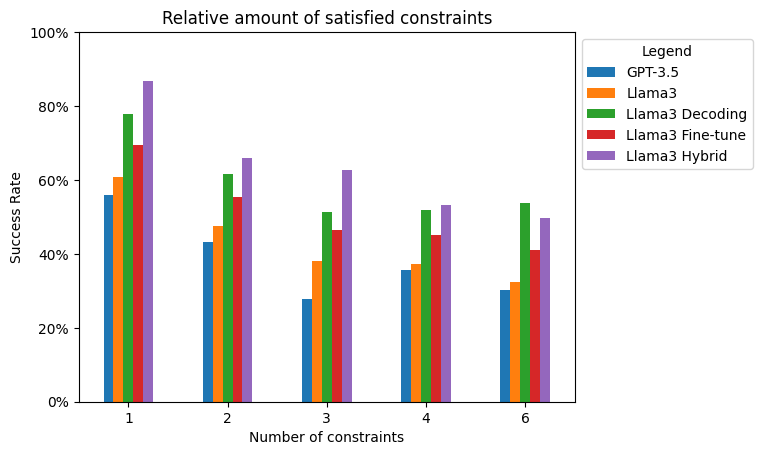

In [33]:
plot_sat(res)

In [7]:
# Test for differences between datasets
data = res[['source','model','num_constraints_sat']+list(gpt_metrics.keys())]
data = data.rename(columns=lambda x: x.replace(' ', '_'))
data.groupby(["source","model"]).agg("mean")

num_constraints_sat  Appropriateness  Relevance  \
source model                                                               
CMUDoG GPT-3.5                      0.497560         4.791304   4.730435   
       Llama3                       0.543919         4.430556   4.263889   
       Llama3 Decoding              0.693318         4.198473   3.984733   
       Llama3 Fine-tune             0.591404         4.040000   3.784000   
       Llama3 Hybrid                0.766329         3.392308   3.092308   
ToC    GPT-3.5                      0.477411         4.738197   4.819742   
       Llama3                       0.525152         4.463878   4.395437   
       Llama3 Decoding              0.697134         4.361011   4.411552   
       Llama3 Fine-tune             0.627468         4.106762   4.064057   
       Llama3 Hybrid                0.763667         3.474453   3.423358   

                         Content_Richness  Grammatical_Correctness  
source model                                                        
CMUDoG GPT-3.5                   3.017391                 4.947826  
       Llama3                    2.840278                 4.916667  
       Llama3 Decoding           2.648855                 4.870229  
       Llama3 Fine-tune          2.200000                 4.680000  
       Llama3 Hybrid             1.915385                 4.138462  
ToC    GPT-3.5                   3.137339                 4.974249  
       Llama3                    2.939163                 4.916350  
       Llama3 Decoding           2.877256                 4.873646  
       Llama3 Fine-tune          2.330961                 4.711744  
       Llama3 Hybrid             2.065693                 4.127737

In [35]:
for metric in data.columns[2:]:
    print(metric)
    model = ols(f'{metric} ~ source * model', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=3) # typ3 because we are mainly interested in the interactions
    print(anova_table)

num_constraints_sat
                   sum_sq      df           F         PR(>F)
Intercept      109.919310     1.0  667.838864  2.330243e-140
source           0.119720     1.0    0.727382   3.937640e-01
model           21.478122     4.0   32.623759   5.657906e-27
source:model     0.613310     4.0    0.931574   4.443832e-01
Residual      1086.291147  6600.0         NaN            NaN
Appropriateness
                   sum_sq      df            F        PR(>F)
Intercept     2640.008696     1.0  2300.824105  0.000000e+00
source           0.217158     1.0     0.189258  6.635825e-01
model          134.978114     4.0    29.409079  8.784572e-24
source:model     2.033050     4.0     0.442962  7.776102e-01
Residual      2252.382987  1963.0          NaN           NaN
Relevance
                   sum_sq      df            F         PR(>F)
Intercept     2573.356522     1.0  1608.363341  2.104008e-257
source           0.614119     1.0     0.383828   5.356336e-01
model          183.385534     4.0   

## Qualitative evaluation

Pick a random test case and print answers from all models

In [21]:
models = ["gpt35", "llama", "llama-FT-multi", "llama-ft-decoding", "llama-decoding-2"]
res, single_constraints = get_res(models)

translate_models(res)
translate_models(single_constraints)

models = list(res.model.unique())
case = res.loc[random.randint(0, max(res.index))]
print("=== DIALOG ===")
print(format_context(case.iloc[0]['context']))
constraints = case.iloc[0]['constraints']
print("=== CONSTRAINTS ===")
for statement in egp[egp['#'].isin(constraints)]['Can-do statement']:
    print(statement)
print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    #print(responses.iloc[0])
    print(f"{responses.iloc[0]['responses0']} ({responses.iloc[0]['num_constraints_sat']:.1%})")

=== DIALOG ===
A: Yeah. I think one year the winner was "It was a dark and story night." Which is funny because that's the real opening line of a kids book I read years ago.
B: That is funny and it doesnt seem that bad either lol, I bet I could do a better job at comming up with a bad oppening sentence.
A: whoops I meant "stormy" not "story." I'm a huge reader, but I've never read Winston Churchill's book that won the Nobel prize. How about you?
B: I didnt know that either, he must have some good litereature pieces then, you know that literature was like an olympic sport before 1952
=== CONSTRAINTS ===
Can form an increasing range of complex noun phrases with a superlative adjective + prepositional phrase, to talk about something unique. ► noun phrases
Can use 'would' to talk about habitual actions and events in the past.
Can form negative statements of main verbs in the present continuous and present perfect with 'be' and 'have' + 'not/n't'.  ► present continuous ► present perfect
===

## Quantitative Evaluation

In [8]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness        \
                                             mean count            mean count   
model            response_hit                                                   
GPT-3.5          0.0                     0.534653   404        4.775862   116   
                 1.0                     0.583732   418        4.783019   106   
Llama3           0.0                     0.633663   404        4.519685   127   
                 1.0                     0.583732   418        4.609023   133   
Llama3 Decoding  0.0                     0.774752   404        4.373984   123   
                 1.0                     0.782297   418        4.511111   135   
Llama3 Fine-tune 0.0                     0.648515   404        3.933333   105   
                 1.0                     0.736842   418        4.292517   147   
Llama3 Hybrid    0.0                     0.871287   404        3.722689   119   
                 1.0                     0.863636   418        3.843284   134   

                              Relevance       Content Richness        \
                                   mean count             mean count   
model            response_hit                                          
GPT-3.5          0.0           4.818966   116         3.051724   116   
                 1.0           4.792453   106         3.188679   106   
Llama3           0.0           4.267717   127         2.763780   127   
                 1.0           4.571429   133         2.842105   133   
Llama3 Decoding  0.0           4.178862   123         2.650407   123   
                 1.0           4.474074   135         2.748148   135   
Llama3 Fine-tune 0.0           3.685714   105         2.133333   105   
                 1.0           4.210884   147         2.251701   147   
Llama3 Hybrid    0.0           3.638655   119         2.042017   119   
                 1.0           3.835821   134         2.208955   134   

                              Grammatical Correctness        
                                                 mean count  
model            response_hit                                
GPT-3.5          0.0                         4.982759   116  
                 1.0                         4.962264   106  
Llama3           0.0                         4.929134   127  
                 1.0                         4.894737   133  
Llama3 Decoding  0.0                         4.894309   123  
                 1.0                         4.955556   135  
Llama3 Fine-tune 0.0                         4.552381   105  
                 1.0                         4.802721   147  
Llama3 Hybrid    0.0                         4.386555   119  
                 1.0                         4.305970   134

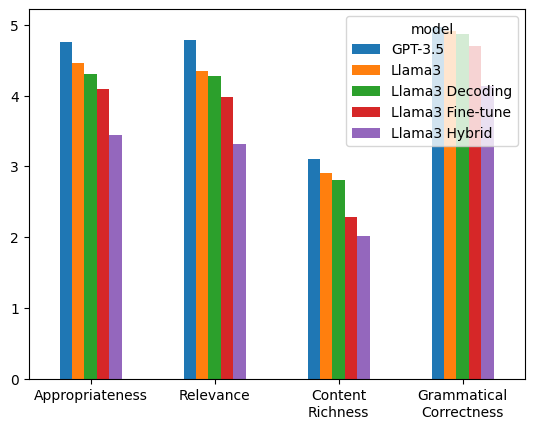

In [39]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in gpt_metrics.keys()}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

In [42]:
models

['gpt35', 'llama', 'llama-FT-multi', 'llama-ft-decoding', 'llama-decoding-2']

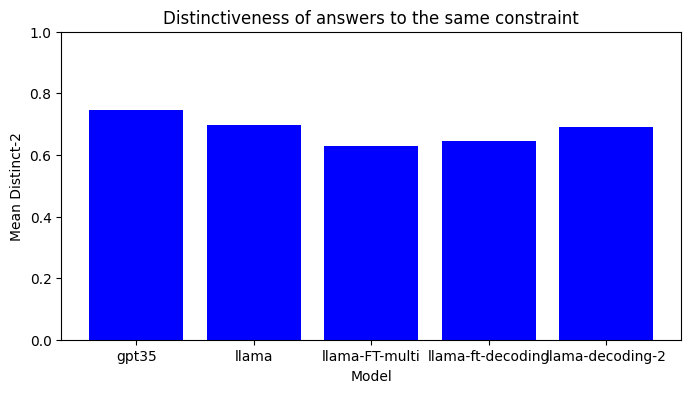

In [9]:
_, single_constraints = get_res(models)
plt.figure(figsize=(8, 4))
plt.bar(models, [get_mean_distinct(model, single_constraints) for model in models], color='blue')
plt.xlabel('Model')
plt.ylabel('Mean Distinct-2')
plt.ylim(0,1)
plt.title('Distinctiveness of answers to the same constraint')
plt.show()

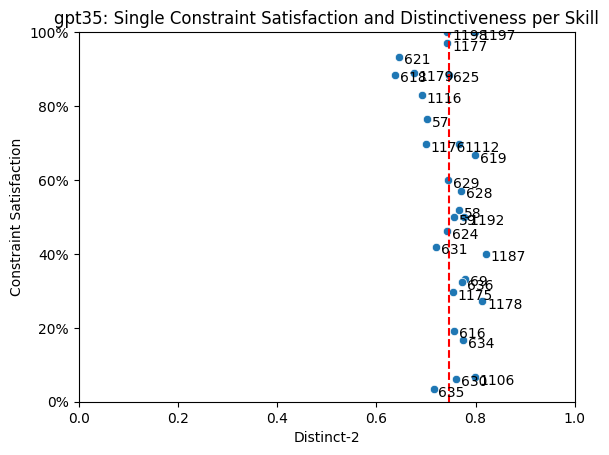

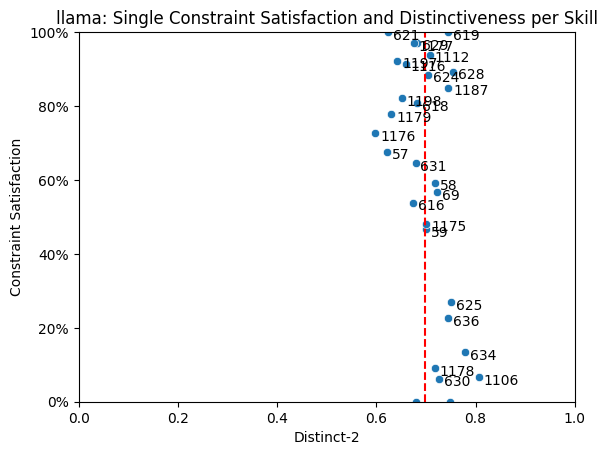

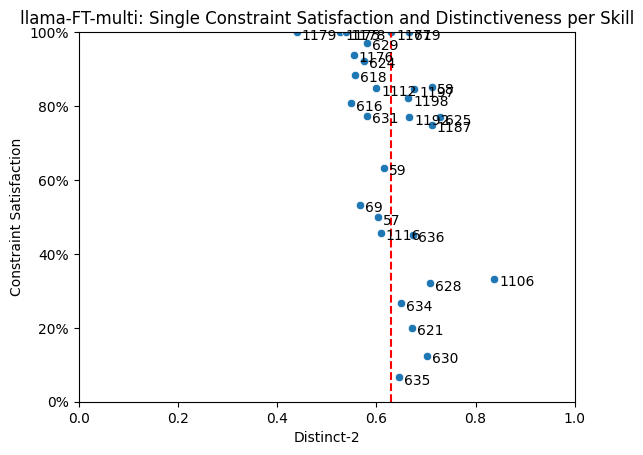

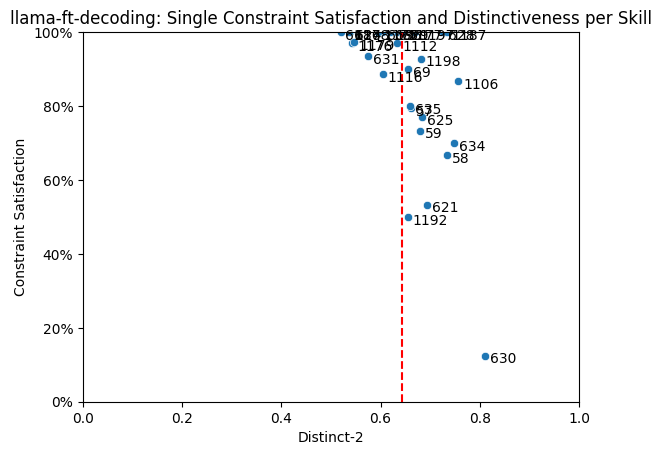

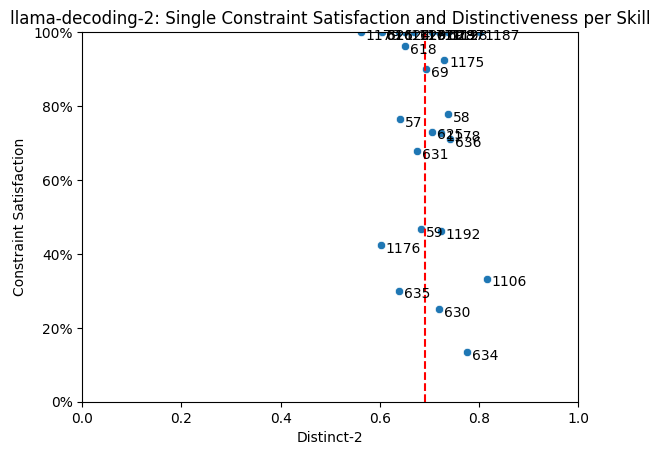

In [10]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

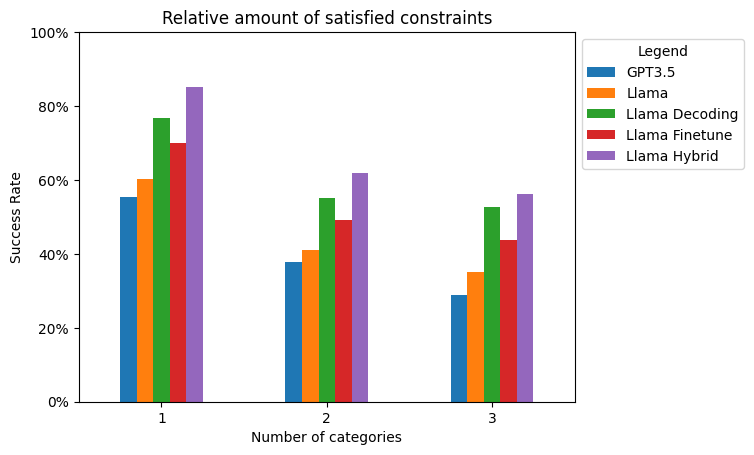

In [15]:
plot_sat(res, by="n_subcats", xlabel="Number of categories")

Report as a table

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tab = get_aggs(res, ["model", "num_constraints"]).unstack(level=0)["num_constraints_sat"]['mean'].transpose()
tab['Mean'] = tab.iloc[:, :5].mean(axis=1)
tab.iloc[:, :6] = tab.iloc[:, :6].applymap(lambda x: f'{x*100:.1f}%')
tab.columns.name = "Number of constraints"
tab

Number of constraints,1,2,3,4,6,Mean
model,,,,,,
gpt35,56.0%,43.2%,27.7%,35.8%,30.2%,38.6%
llama,60.8%,47.5%,38.0%,37.2%,32.3%,43.2%
llama-FT-multi,69.3%,55.5%,46.3%,45.0%,41.2%,51.5%
llama-decoding-2,77.9%,61.5%,51.3%,51.7%,53.8%,59.3%
llama-ft-decoding,86.7%,66.0%,62.7%,53.2%,49.8%,63.7%


In [20]:
latex_table = tab.to_latex(escape=True)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
Number of constraints & 1 & 2 & 3 & 4 & 6 & Mean \\
model &  &  &  &  &  &  \\
\midrule
GPT-3.5 & 56.0\% & 43.2\% & 27.7\% & 35.8\% & 30.2\% & 38.6\% \\
Llama3 & 60.8\% & 47.5\% & 38.0\% & 37.2\% & 32.3\% & 43.2\% \\
Llama3 Decoding & 77.9\% & 61.5\% & 51.3\% & 51.7\% & 53.8\% & 59.3\% \\
Llama3 Fine-tune & 69.3\% & 55.5\% & 46.3\% & 45.0\% & 41.2\% & 51.5\% \\
Llama3 Hybrid & 86.7\% & 66.0\% & 62.7\% & 53.2\% & 49.8\% & 63.7\% \\
\bottomrule
\end{tabular}



In [11]:
def get_avg_wpm(model):
    times = pd.read_json(f"../data/task1/{model}-time.json")
    return f"{int((times['responses'].apply(lambda x: len(x[0].split())) / times['time'] * 60).mean().round(0))} wpm"

In [39]:
res, single_constraints = get_res(models)
tab = pd.DataFrame()
for ind in gpt_metrics.keys():
    tab[ind] = get_aggs(res, ["model"])[ind]['mean']

tab['Distinct-2'] = [get_mean_distinct(model, single_constraints) for model in tab.index]
tab['Inference'] = [get_avg_wpm(model) for model in tab.index]
tab.iloc[:, :5] = tab.iloc[:, :5]
tab.columns.name = ""
tab.index = tab.index.map(translation_dict)
#tab = tab
tab.iloc[[0,1,3,2,4]]

,Appropriateness,Relevance,Content Richness,Grammatical Correctness,Distinct-2,Inference
model,,,,,,
GPT-3.5,4.755747,4.790230,3.097701,4.965517,0.747323,1650 wpm
Llama3,4.452088,4.348894,2.904177,4.916462,0.698673,695 wpm
Llama3 Decoding,4.308824,4.274510,2.803922,4.872549,0.691860,524 wpm
Llama3 Fine-tune,4.086207,3.977833,2.290640,4.701970,0.628904,634 wpm
Llama3 Hybrid,3.448020,3.316832,2.017327,4.131188,0.643881,344 wpm


In [40]:
tab.iloc[:, :5] = tab.iloc[:, :5].applymap(lambda x: f'{x:.2f}')
latex_table = tab.iloc[[0,1,3,2,4]].to_latex(escape=True)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
 & Appropriateness & Relevance & Content Richness & Grammatical Correctness & Distinct-2 & Inference \\
model &  &  &  &  &  &  \\
\midrule
GPT-3.5 & 4.76 & 4.79 & 3.10 & 4.97 & 0.75 & 1650 wpm \\
Llama3 & 4.45 & 4.35 & 2.90 & 4.92 & 0.70 & 695 wpm \\
Llama3 Decoding & 4.31 & 4.27 & 2.80 & 4.87 & 0.69 & 524 wpm \\
Llama3 Fine-tune & 4.09 & 3.98 & 2.29 & 4.70 & 0.63 & 634 wpm \\
Llama3 Hybrid & 3.45 & 3.32 & 2.02 & 4.13 & 0.64 & 344 wpm \\
\bottomrule
\end{tabular}



## Constraint difficulty

In [44]:
def get_best_singles( models):
    best = res[res['model'].isin(models)].copy()
    best['combined'] = best.apply(lambda row: list(zip(row['constraints'], row['positive_constraints'])), axis=1)
    singles = best[['combined', 'num_constraints', 'model']].explode('combined').reset_index(drop=True)
    singles[['constraint', 'satisfied']] = singles['combined'].apply(pd.Series)
    singles.drop(columns="combined")
    singles = singles[~singles.constraint.isin([1106,1112,1116])]
    singles['num_constraints'] = singles['num_constraints'] > 1
    singles['Category'] = singles['constraint'].map(egp['SubCategory']).apply(lambda x: x.capitalize())
    return best, singles

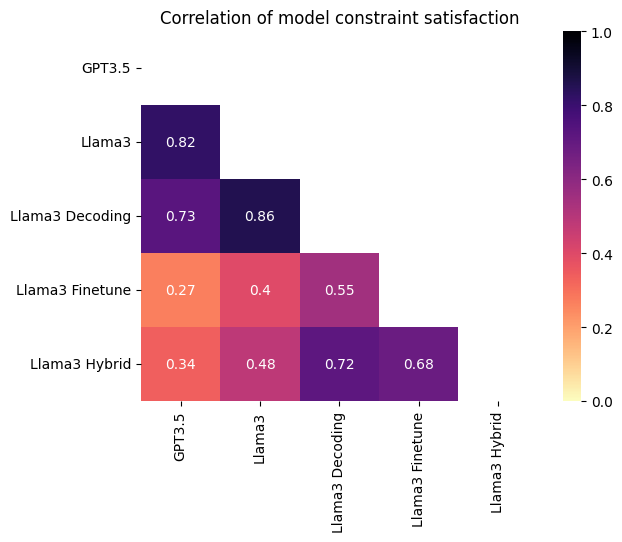

In [8]:
models = list(translation_dict.values())
best, singles = get_best_singles(models)
constraint_model = singles.groupby(["model", "constraint"]).agg({"satisfied": "mean"})
corrs = constraint_model.reset_index().pivot(index="constraint", columns="model", values="satisfied").corr()
heatmap = sns.heatmap(corrs, vmin=0, vmax=1, annot=True, mask=np.triu(np.ones_like(corrs, dtype=bool)), cmap=sns.color_palette("magma_r", as_cmap=True))
heatmap.set(xlabel=None, ylabel=None, title="Correlation of model constraint satisfaction")
plt.savefig("../results/constraint_correlation.pdf", bbox_inches="tight")
plt.show()

In [9]:
constraint_sat = singles.groupby(["constraint", "num_constraints"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint", columns=["num_constraints"])['satisfied']
pearsonr(constraint_sat[True], constraint_sat[False])

PearsonRResult(statistic=0.8869146985352134, pvalue=1.6028894883960743e-09)

In [46]:
models = ["GPT3.5", "Llama3", "Llama3 Decoding"]
translate_models(res)
best, singles = get_best_singles(models)
constraint_model = singles.groupby(["model", "constraint"]).agg({"satisfied": "mean"})

In [ ]:
res

In [47]:
models = ["GPT3.5", "Llama3", "Llama3 Decoding", "Llama3 Finetune", "Llama3 Hybrid"]
_, all_models = get_best_singles(models)
df = all_models.groupby(["model", "constraint"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint",columns="model",values="satisfied")
df_percentage = df.applymap(lambda x: f"{x*100:.1f}%")
print(df_percentage.to_latex().replace("%","\%").replace("\\\n", "\\ \hline\n"))

\begin{tabular}{llll}
\toprule
model & Llama3 & Llama3 Decoding & Llama3 Hybrid \\ \hline
constraint &  &  &  \\ \hline
\midrule
57 & 65.0\% & 71.2\% & 45.8\% \\ \hline
58 & 42.7\% & 52.2\% & 51.0\% \\ \hline
59 & 32.4\% & 31.3\% & 42.3\% \\ \hline
69 & 37.4\% & 46.8\% & 36.3\% \\ \hline
616 & 32.8\% & 83.6\% & 83.6\% \\ \hline
618 & 74.0\% & 90.9\% & 87.0\% \\ \hline
619 & 85.5\% & 78.3\% & 86.7\% \\ \hline
621 & 86.5\% & 80.8\% & 26.9\% \\ \hline
624 & 73.4\% & 81.0\% & 82.3\% \\ \hline
625 & 35.8\% & 67.2\% & 62.7\% \\ \hline
628 & 66.2\% & 90.1\% & 88.7\% \\ \hline
629 & 71.6\% & 80.2\% & 87.7\% \\ \hline
630 & 11.1\% & 25.4\% & 9.5\% \\ \hline
631 & 54.3\% & 57.1\% & 58.6\% \\ \hline
634 & 7.9\% & 6.3\% & 42.9\% \\ \hline
635 & 0.0\% & 16.0\% & 54.7\% \\ \hline
636 & 17.3\% & 45.7\% & 63.0\% \\ \hline
1175 & 30.1\% & 68.8\% & 76.3\% \\ \hline
1176 & 45.8\% & 57.3\% & 84.4\% \\ \hline
1177 & 68.4\% & 92.4\% & 98.7\% \\ \hline
1178 & 5.1\% & 38.0\% & 82.3\% \\ \hline
1179 & 44.3\% &

In [48]:
max_satisfaction = constraint_model.groupby("constraint").agg({"satisfied": "max"}).reset_index()

In [49]:

best, singles = get_best_singles(models)

In [52]:
constraint_sat = singles.groupby(["constraint", "num_constraints"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint", columns=["num_constraints"])['satisfied']
pearsonr(constraint_sat[True], constraint_sat[False])

PearsonRResult(statistic=0.8098041548565151, pvalue=5.401683962940486e-07)

Check distictiveness

In [70]:
res, single_constraints = get_res(["llama-decoding-2"], ['CMUDoG', 'ToC', 'WoW', 'DialogSum', 'DialogSum'])
dists = get_aggs(single_constraints, ["constraint"], distinct=True)
pearsonr(dists[("num_constraints_sat","mean")], dists[("responses0", "calculate_distinct_n")])

PearsonRResult(statistic=-0.11792872584100116, pvalue=0.5423502107585999)

In [72]:
dists
print([pearsonr(dists[("num_constraints_sat","mean")], dists[(metric, "mean")]) for metric in gpt_metrics.keys()])

[PearsonRResult(statistic=0.36155313976980175, pvalue=0.0539617342316193), PearsonRResult(statistic=0.33016342624869555, pvalue=0.0802554636090446), PearsonRResult(statistic=0.21366649217153114, pvalue=0.2657387446820995), PearsonRResult(statistic=0.24605813149920014, pvalue=0.19821029319823505)]


In [68]:
def describe(x):
    skill = egp[egp['#']==int(x.get_text())].iloc[0]
    x.set_text(str(skill['#']) + ": " + skill['guideword'][skill['guideword'].index(':')+2:].capitalize())
    return x

/tmp/ipykernel_3769160/2051065043.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_3769160/2051065043.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([describe(label) for label in g.ax.get_xticklabels()], rotation=45, ha='right')


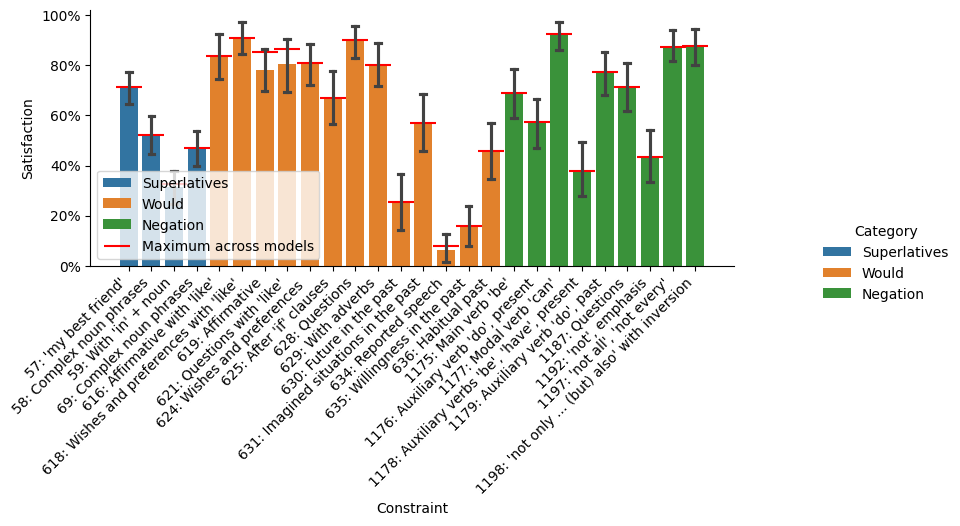

In [69]:
g=sns.catplot(singles, kind="bar", x="constraint", y='satisfied', hue="Category", dodge=False, errorbar="ci", capsize=.25, legend=True)
g.fig.set_size_inches(10,3)
#g.ax.set_title("Satisfaction by Constraint")
g.ax.set_ylabel("Satisfaction")
g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
g.ax.set_xlabel("Constraint")
g.ax.set_xticklabels([describe(label) for label in g.ax.get_xticklabels()], rotation=45, ha='right')

ax = g.facet_axis(0, 0)
ax.scatter(max_satisfaction.index, max_satisfaction['satisfied'], color='red', marker='_', s=350, label="Maximum across models")
ax.legend()
g.savefig("../results/constraint_difficulty.pdf")
plt.show()

In [73]:
singles.groupby("constraint").agg({"satisfied": "mean"}).sort_values("satisfied")

,satisfied
constraint,
634,0.063492
635,0.160000
630,0.253968
59,0.313187
1178,0.379747
1192,0.432099
636,0.456790
69,0.468421
58,0.522293


# Task 2

In [3]:
def categories_satisfied(row, type='positive'):
    df = pd.DataFrame({'score': row[f'{type}_constraints'], 'category': row[f'{type}_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)>0})['score'])

In [31]:
models = ["gpt35", "llama", "llama-ft", "llama-decoding", "llama-ft-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task2/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['num_constraints'] = results['positive_constraints'].apply(len)
    results['num_categories'] = results['categories'].apply(len)
    results['num_categories_sat'] = results.apply(categories_satisfied, axis=1)
    results['num_categories_neg'] = results.apply(categories_satisfied, axis=1, args=['negative'])
    res = pd.concat([res, results])
translate_models(res)

Number of constraints

,context,response,source,id,categories,levels,responses,positive_constraints,positive_categories,negative_constraints,negative_categories,Appropriateness,Relevance,Content Richness,Grammatical Correctness,num_constraints,num_categories,num_categories_sat,num_categories_neg
model,,,,,,,,,,,,,,,,,,,
GPT-3.5,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,500,500,500,500,1500,1500,1500,1454
Llama3,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,501,501,501,501,1500,1500,1500,1454
Llama3 Decoding,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,500,500,500,500,1500,1500,1500,1454
Llama3 Fine-tune,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,500,500,500,500,1500,1500,1500,1454
Llama3 Hybrid,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,500,500,500,500,1500,1500,1500,1454


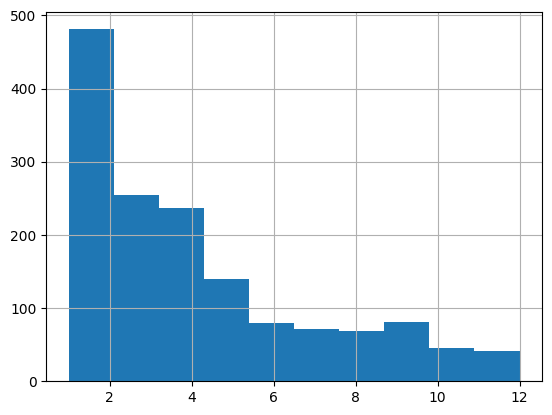

In [32]:
results['num_constraints'].hist()

res.groupby("model").agg("count")

## Qualitative Evaluation

In [5]:
case = res.loc[random.randint(0, max(res.index))]
msg = get_prompt_task_2(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in res.model.unique(): 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['num_categories_sat']:.0%}/{responses.iloc[0]['num_categories_neg']:.0%})")

Given the dialog, write a possible next turn of A that preferably uses the following grammatical items in the response:
- superlatives on CEFR level A2 (FORM/USE: COMPLEX NOUN PHRASES; FORM/USE: WITH 'IN' + NOUN)
- would on CEFR level B2 (USE: HABITUAL PAST)
Dialog:
A: I know right! I wouldn't either if they pay me in the millions or a potential of it haha and I didnt know that about the Jordans, I did know that Nike offered Lebron 90 million, shortly after reebok offered him 10 million that Lebron rejected! Who rejects 10 mil! Oh my Lordy!
B: Wow! It's a good thing he rejected though. He earned himself 80 million! Yeah I guess Jordan wore his Jordans anyway, because NIKE was willing to pay the fine each time! That worked well for them, I think!
A: I know!! Its almost like he expected it, but when you are that good I guess you expect it, its good business! I wouldn't have rejected probably unless I was coached into it. It makes sense though
B: Yeah I definitely wouldn't have rejected t

## Quantitative evaluation

In [23]:
def plot_combined(res_melt, hue="Alpha", save=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, hue_order=['GPT-3.5', 'Llama3', 'Llama3 Fine-tune', 'Llama3 Decoding', 'Llama3 Hybrid'], y='Value', errorbar="ci", capsize=.1)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=5, title=None, frameon=False,
    )
    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraint\nSatisfaction"
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

/tmp/ipykernel_109428/2401139386.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_109428/2401139386.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_109428/2401139386.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


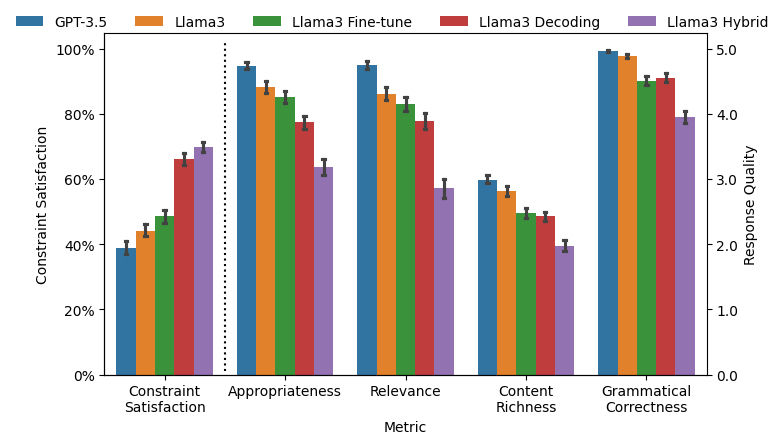

In [33]:
res_melt = res[['model','num_categories_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_categories_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task2.pdf")

In [135]:
# Test for differences between datasets
data = res[['source','model','num_categories_sat']+list(gpt_metrics.keys())]
data = data.rename(columns=lambda x: x.replace(' ', '_'))
data.groupby(["source","model"]).agg("mean")

num_categories_sat  Appropriateness  Relevance  \
source model                                                              
CMUDoG GPT-3.5                     0.407282         4.594937   4.594937   
       Llama3                      0.408784         4.320388   4.281553   
       Llama3 Decoding             0.644520              NaN        NaN   
       Llama3 Fine-tune            0.506381         4.833333   4.500000   
       Llama3 Hybrid               0.690691              NaN        NaN   
ToC    GPT-3.5                     0.379735         4.809942   4.824561   
       Llama3                      0.455966         4.470899   4.380952   
       Llama3 Decoding             0.668561              NaN        NaN   
       Llama3 Fine-tune            0.477588         4.600000   4.666667   
       Llama3 Hybrid               0.702336              NaN        NaN   

                         Content_Richness  Grammatical_Correctness  
source model                                                        
CMUDoG GPT-3.5                   2.778481                 4.974684  
       Llama3                    2.718447                 4.932039  
       Llama3 Decoding                NaN                      NaN  
       Llama3 Fine-tune          2.333333                 5.000000  
       Llama3 Hybrid                  NaN                      NaN  
ToC    GPT-3.5                   3.093567                 4.973684  
       Llama3                    2.952381                 4.873016  
       Llama3 Decoding                NaN                      NaN  
       Llama3 Fine-tune          2.866667                 4.333333  
       Llama3 Hybrid                  NaN                      NaN

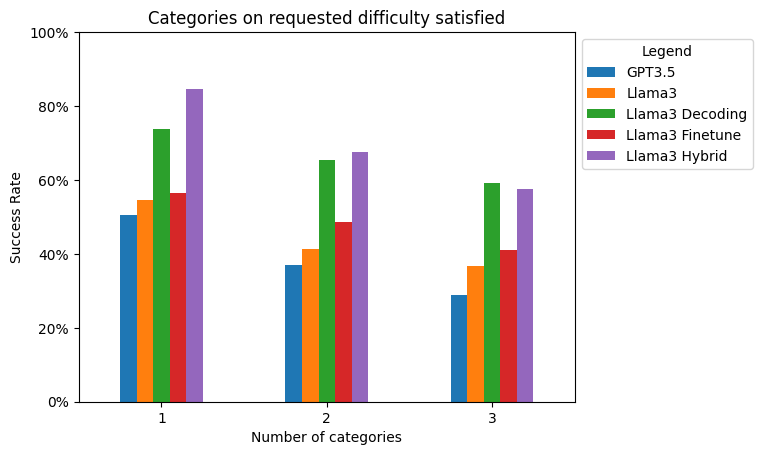

In [18]:
plot_sat(res, col='num_categories_sat', by='num_categories', xlabel="Number of categories", title="Categories on requested difficulty satisfied")

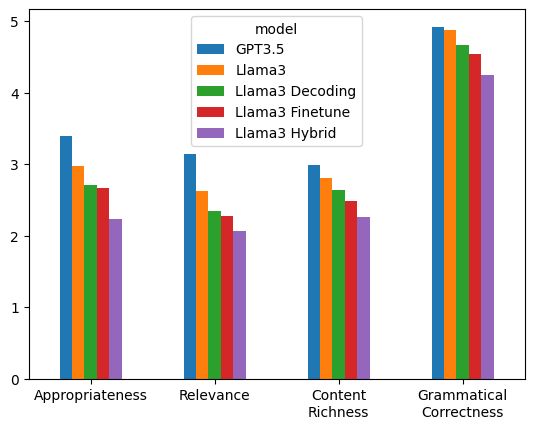

In [19]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

In [25]:
get_aggs(res, by=["model"], aggs=['num_categories_neg'])

num_categories_sat       num_categories_neg Appropriateness  \
                              mean count               mean            mean   
model                                                                         
GPT3.5                    0.387889  1500           0.046884           3.388   
Llama3                    0.442000  1500           0.050820           2.976   
Llama3 Decoding           0.661444  1500           0.077371           2.704   
Llama3 Finetune           0.486111  1500           0.079814           2.662   
Llama3 Hybrid             0.698889  1500           0.061646           2.232   

                      Relevance       Content Richness        \
                count      mean count             mean count   
model                                                          
GPT3.5            500     3.144   500            2.984   500   
Llama3            500     2.626   500            2.810   500   
Llama3 Decoding   500     2.348   500            2.634   500   
Llama3 Finetune   500     2.276   500            2.492   500   
Llama3 Hybrid     500     2.066   500            2.260   500   

                Grammatical Correctness        
                                   mean count  
model                                          
GPT3.5                            4.916   500  
Llama3                            4.882   500  
Llama3 Decoding                   4.672   500  
Llama3 Finetune                   4.544   500  
Llama3 Hybrid                     4.246   500

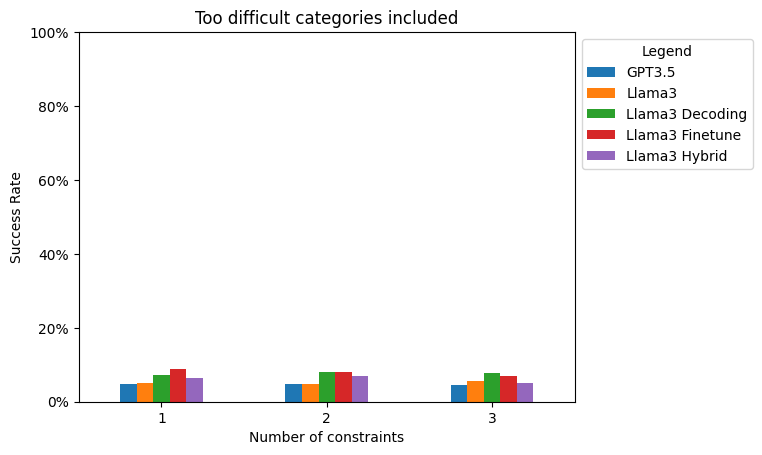

In [20]:
plot_sat(res, col='num_categories_neg', by='num_categories', title="Too difficult categories included")

# Task 3

In [67]:
models = ["gpt35", "llama", "llama-decoding", "llama-ft","llama-ft-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task3/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['level_sat'] = results['positive_constraints'].apply(np.mean)
    results['level_neg'] = results['negative_constraints'].apply(np.mean)
    results['diff'] = results['level_sat'] - results['level_neg']
    res = pd.concat([res, results])

translate_models(res)

In [68]:
case = res.loc[random.sample(list(res.index), k=1)[0]]
msg = get_prompt_task_3(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in res.model.unique(): 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['level_sat']:.0%}/{responses.iloc[0]['level_neg']:.0%})")

Given the dialog, write a possible next turn of A that uses grammatical items on CEFR level B1.
Dialog:
A: I like that the movie is framed with Nick's time in rehab, telling the story of Gatsby.
B: yeah exactly! I liked that it was told from outside point of view because if it were from Gatsby it would be like "why doesn't she like my epic parties?????"" lmao
A: Apparently the green light is an important example of symbolism
B: Gatsby's version would be boring. He would spend all of the time describing how great the parties are and how expensive everything is.

=== RESPONSES ===
Model: GPT3.5
A: Yeah, I agree. It's interesting how the green light represents Gatsby's hopes and dreams for the future. (0%/0%)
Model: Llama3
A: Yeah, I think that's what makes the movie interesting, it's not just about Gatsby's wealth and parties, it's about the themes and characters. (0%/0%)
Model: Llama3 Decoding
A: Yeah, I didn't like that about Gatsby's book. It felt very one-sided. (0%/0%)
Model: Llama3

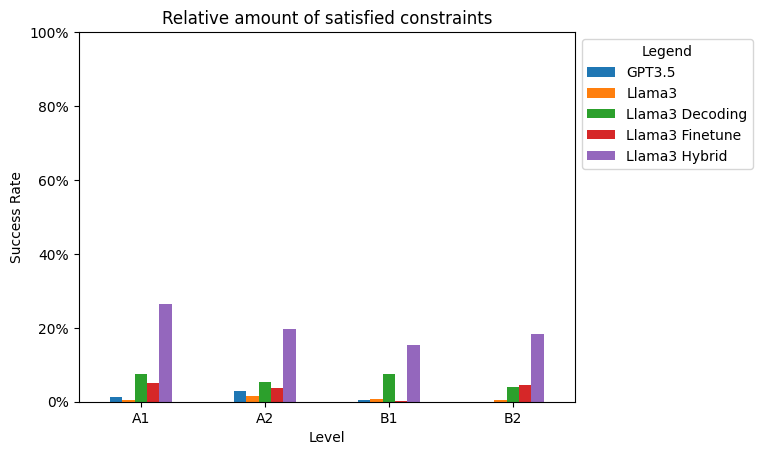

In [41]:
plot_sat(res, col="level_sat", by="level", xlabel="Level")

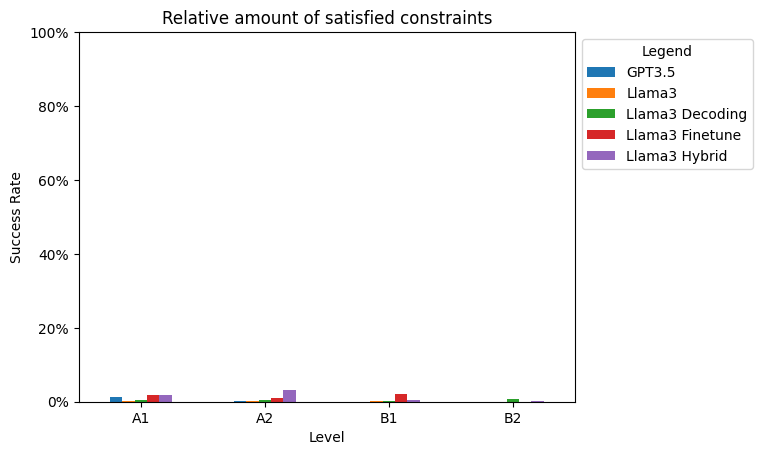

In [42]:
plot_sat(res, col="level_neg", by="level", xlabel="Level")

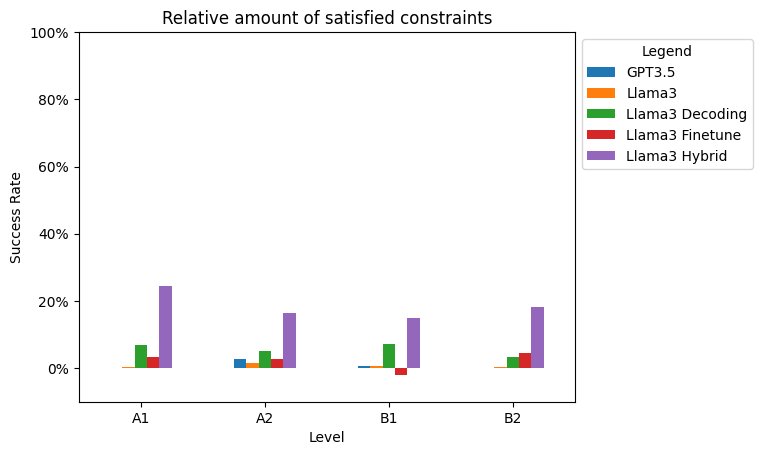

In [43]:
plot_sat(res, col="diff", by="level", xlabel="Level", ylim=(-0.1,1))

/tmp/ipykernel_3005845/3193045787.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])


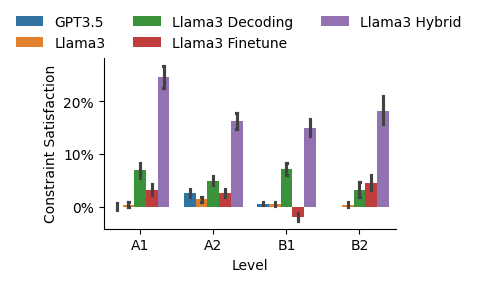

In [66]:
def plot_combined(res_melt, hue, save=None):
    g=sns.catplot(res_melt, kind="bar", x="level", hue=hue, y='Value', errorbar="ci", capsize=.025)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=3, title=None, frameon=False,
    )
    g.fig.set_size_inches(5,2)
    g.ax.set_xlabel("Level")
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    
    if save: g.savefig(save)
    plt.show()

res_melt = res[['model', 'level', 'diff']].melt(['model','level'], var_name='Metric', value_name='Value')
#res_melt.loc[res_melt['Metric']!="diff",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task3.pdf")

/tmp/ipykernel_3005845/341367544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_3005845/341367544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_3005845/341367544.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


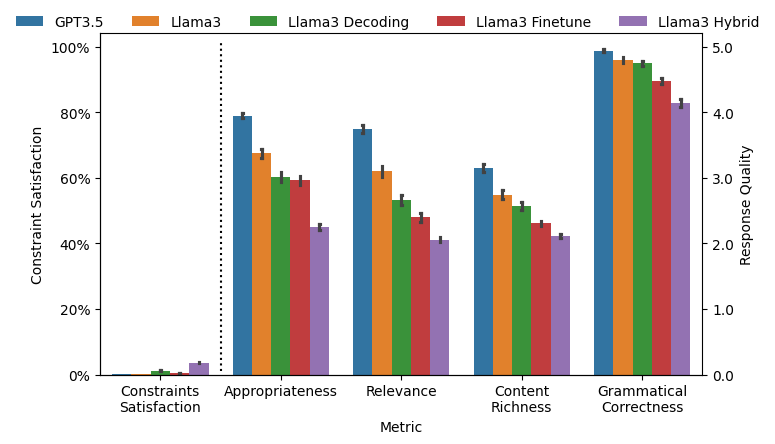

In [69]:

def plot_combined(res_melt, hue="Alpha", save=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, y='Value', errorbar="ci", capsize=.025)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=5, title=None, frameon=False,
    )
    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraints\nSatisfaction"
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

res_melt = res[['model','diff']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_categories_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task2.pdf", )


In [76]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False, aggs = []):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_categories_neg': ['mean']} if 'num_categories_neg' in results.columns else {}
    neg_const = {agg: ['mean'] for agg in aggs} if aggs else {}
    agg_col = "num_categories" if 'num_categories_neg' in results.columns else "num_constraints"
    agg_col = "level" if 'level' in results.columns else agg_col
    aggs = results.groupby(by).agg({f'{by[1] if len(by)>1 else agg_col}_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in gpt_metrics.keys()}})
    return aggs
get_aggs(res, ["model"])#.unstack(level=0)["num_constraints_sat"]['mean'].transpose()

level_sat       Appropriateness       Relevance        \
                     mean count            mean count      mean count   
model                                                                   
GPT3.5           0.012580  1000           3.950   500     3.748   500   
Llama3           0.008066  1000           3.374   500     3.102   500   
Llama3 Decoding  0.062293  1000           3.008   500     2.658   500   
Llama3 Finetune  0.034098  1000           2.966   500     2.402   500   
Llama3 Hybrid    0.197471  1000           2.250   500     2.054   500   

                Content Richness       Grammatical Correctness        
                            mean count                    mean count  
model                                                                 
GPT3.5                     3.152   500                   4.942   500  
Llama3                     2.740   500                   4.798   500  
Llama3 Decoding            2.574   500                   4.748   500  
Llama3 Finetune            2.306   500                   4.486   500  
Llama3 Hybrid              2.108   500                   4.144   500